In [1]:
import h5py
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
filename = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/Test_Final_LXG_DSP.h5'

distance_thresh = 100 # for the global attribution average plot
attr_segment_length = 20 # num codons on each side

# load h5
int_ds = h5py.File(filename, 'r')
int_ds.keys()

id_to_codon = {idx:''.join(el) for idx, el in enumerate(itertools.product(['A', 'T', 'C', 'G'], repeat=3))}
codon_to_id = {v:k for k,v in id_to_codon.items()}

In [3]:
# make a dataframe
distance_from_A_site = []
attribution_value = []
codon_id = []

len_samples = len(int_ds['node_attr'])

for i in tqdm(range(len_samples)):
    node_attr_sample = int_ds['node_attr'][i]
    x_input_sample = int_ds['x_input'][i]
    # # take absolute value
    # node_attr_sample = np.abs(node_attr_sample)
    # num codons is square root of length of node_attr_sample
    num_codons = int(len(node_attr_sample)**0.5) 
    # convert to 2D array of shape (num_codons, num_codons)
    node_attr_sample = node_attr_sample.reshape(num_codons, num_codons)
    # remove virtual node codon
    node_attr_sample = node_attr_sample[:-1, :-1]

    # iterate over each row
    for j in range(num_codons-1):
        # iterate over each column
        # normalize this row by dividing by the max value
        node_attr_sample[j] = node_attr_sample[j] / np.sum(np.abs(node_attr_sample[j]))
        for k in range(num_codons-1):
            # add to the dataframe
            if abs(j-k) <= distance_thresh:
                distance_from_A_site.append(j-k)
                attribution_value.append(node_attr_sample[j][k])
                codon_id.append(id_to_codon[x_input_sample[k]])

# # make a dict
data = {'Offset from A site (codons)': distance_from_A_site, 'Attribution': attribution_value, 'Codon': codon_id}

# make a dataframe
df_distance_attr = pd.DataFrame(data)
df_distance_attr.to_pickle('final_plots/df_distance_attr.pkl.zip', compression='zip')

# df_distance_attr = pd.read_pickle('final_plots/df_distance_attr.pkl.zip')

100%|██████████| 1397/1397 [02:57<00:00,  7.89it/s]


/tmp/ipykernel_2128695/1036010670.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  b = sns.lineplot(x='Offset from A site (codons)', y='Attribution', data=df_distance_attr_full, color='#e74c3c', ci='sd')


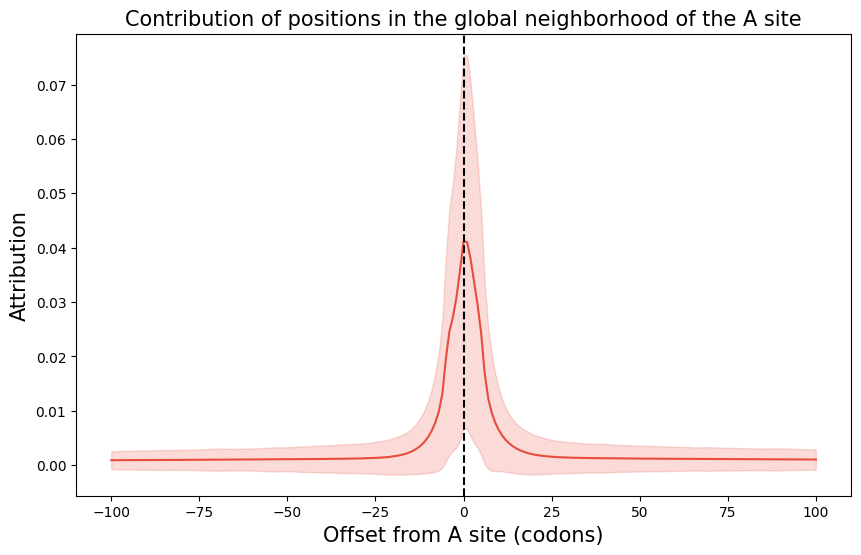

In [4]:
# make a bar plot for ds_attr_dist from distance -100 to +100
# group by and mean atribution
# remove codon column
df_distance_attr_full = df_distance_attr.drop('Codon', axis=1)
# make atribution values absolute
df_distance_attr_full['Attribution'] = np.abs(df_distance_attr_full['Attribution'])

# group by and mean
# df_distance_attr_full = df_distance_attr_full.groupby('Offset from A site (codons)', as_index=False)['Attribution'].mean()

plt.figure(figsize=(10, 6))
b = sns.lineplot(x='Offset from A site (codons)', y='Attribution', data=df_distance_attr_full, color='#e74c3c', ci='sd')
# change font style to sans-serif
# plt.xlim(-100, 100)
b.axes.set_title("Contribution of positions in the global neighborhood of the A site", fontsize=15, fontname='sans-serif')
b.set_xlabel("Offset from A site (codons)", fontsize=15, fontname='sans-serif')
b.set_ylabel("Attribution", fontsize=15, fontname='sans-serif')
plt.axvline(x=0, color='black', linestyle='--')

plt.savefig('final_plots/offset_attr_global.svg')
plt.savefig('final_plots/offset_attr_global.png')

/tmp/ipykernel_2128695/1260605441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance_attr_local['Attribution'] = np.abs(df_distance_attr_local['Attribution'])


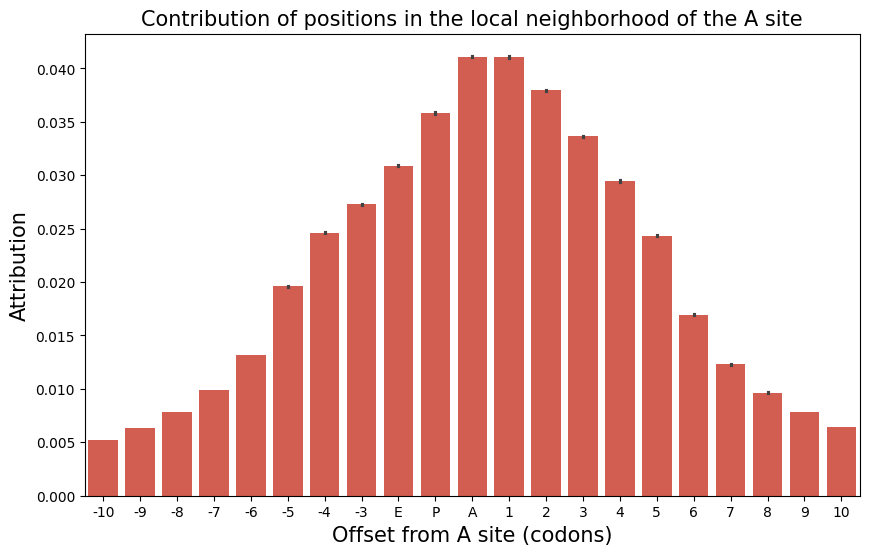

In [5]:
# make a bar plot for ds_attr_dist from distance -10 to +10
df_distance_attr_local = df_distance_attr[df_distance_attr['Offset from A site (codons)'].between(-10, 10)]
# make atribution values absolute
df_distance_attr_local['Attribution'] = np.abs(df_distance_attr_local['Attribution'])
plt.figure(figsize=(10, 6))
b = sns.barplot(x='Offset from A site (codons)', y='Attribution', data=df_distance_attr_local, color='#e74c3c')
# change font style to sans-serif
b.axes.set_title("Contribution of positions in the local neighborhood of the A site", fontsize=15, fontname='sans-serif')
b.set_xlabel("Offset from A site (codons)", fontsize=15, fontname='sans-serif')
b.set_ylabel("Attribution", fontsize=15, fontname='sans-serif')
plt.xticks(range(0, 21), ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.savefig('final_plots/offset_attr_local.svg')
plt.savefig('final_plots/offset_attr_local.png')

/tmp/ipykernel_2128695/1591825883.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance_attr_codon['CodonInt'] = codonintlist


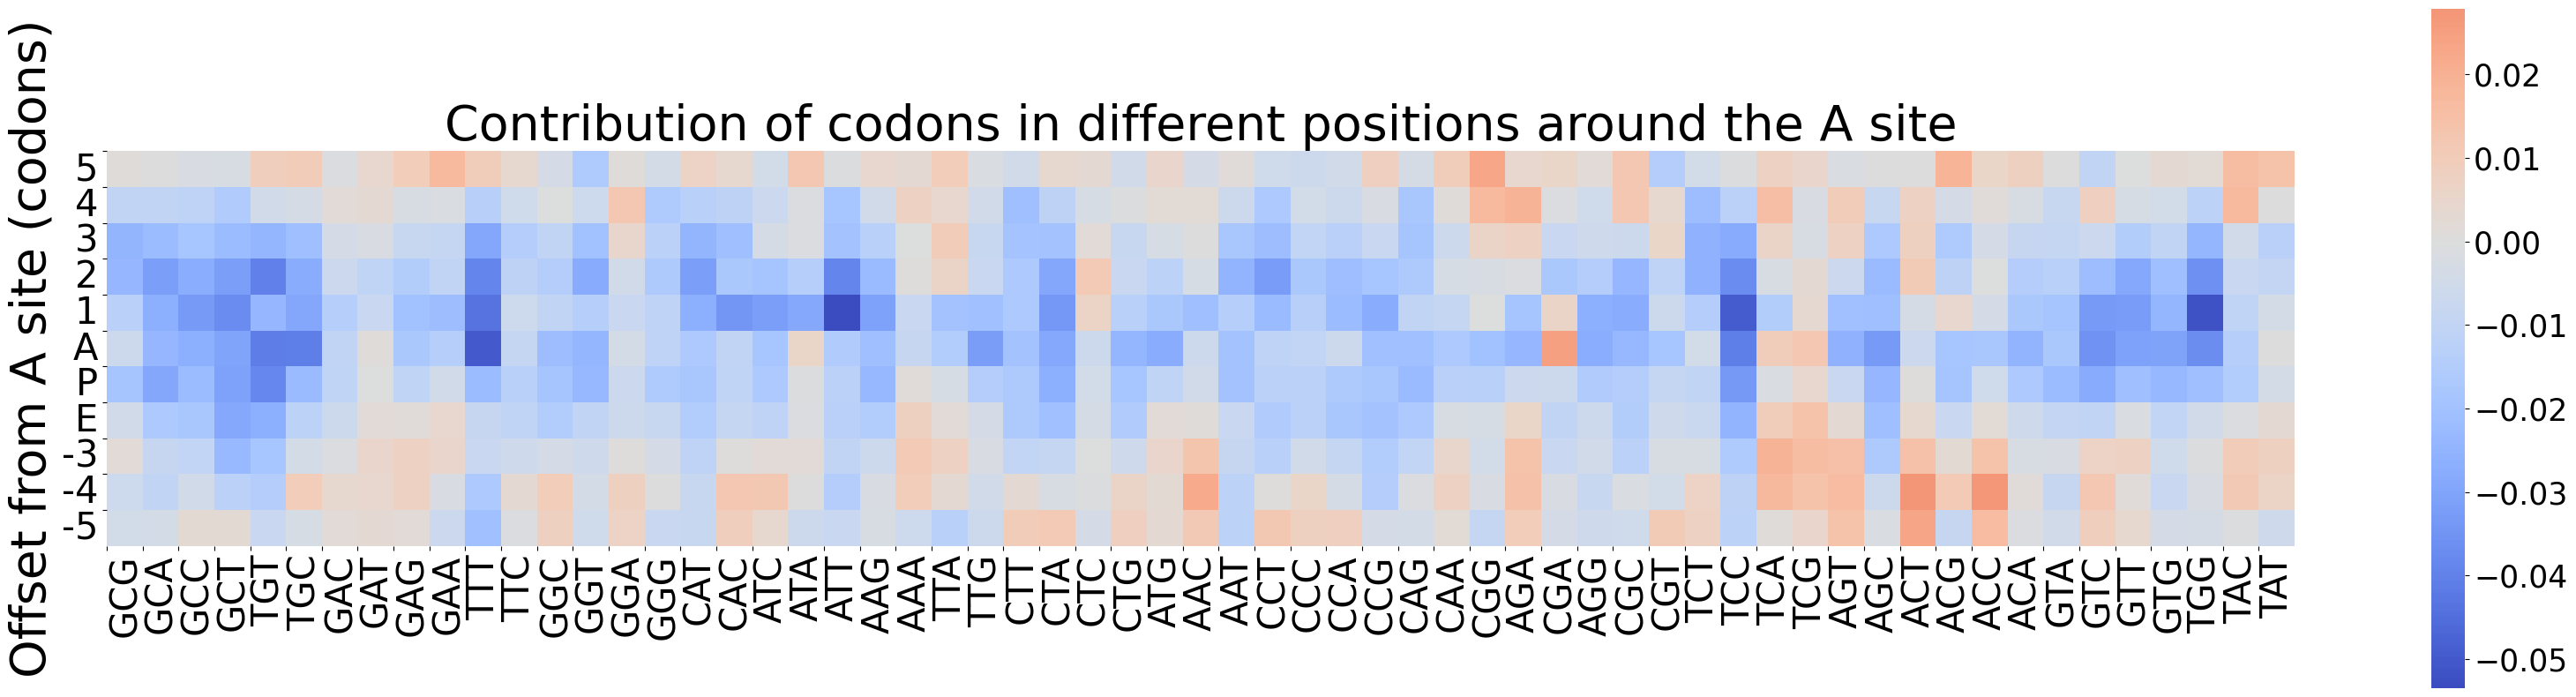

In [6]:
df_distance_attr_codon = df_distance_attr[df_distance_attr['Offset from A site (codons)'].between(-5, 5)] 
# codon to int dictionary
codon_to_id_plot = {
    'GCG': 0,
    'GCA': 1,
    'GCC': 2,
    'GCT': 3,
    'TGT': 4,
    'TGC': 5,
    'GAC': 6,
    'GAT': 7,
    'GAG': 8,
    'GAA': 9,
    'TTT': 10,
    'TTC': 11,
    'GGC': 12,
    'GGT': 13,
    'GGA': 14,
    'GGG': 15,
    'CAT': 16,
    'CAC': 17,
    'ATC': 18,
    'ATA': 19,
    'ATT': 20,
    'AAG': 21,
    'AAA': 22,
    'TTA': 23,
    'TTG': 24,
    'CTT': 25,
    'CTA': 26,
    'CTC': 27,
    'CTG': 28,
    'ATG': 29,
    'AAC': 30,
    'AAT': 31,
    'CCT': 32,
    'CCC': 33,
    'CCA': 34,
    'CCG': 35,
    'CAG': 36,
    'CAA': 37,
    'CGG': 38,
    'AGA': 39,
    'CGA': 40,
    'AGG': 41,
    'CGC': 42,
    'CGT': 43,
    'TCT': 44,
    'TCC': 45,
    'TCA': 46,
    'TCG': 47,
    'AGT': 48,
    'AGC': 49,
    'ACT': 50,
    'ACG': 51,
    'ACC': 52,
    'ACA': 53,
    'GTA': 54,
    'GTC': 55,
    'GTT': 56,
    'GTG': 57,
    'TGG': 58,
    'TAC': 59,
    'TAT': 60,
    'TAA': 61,
    'TGA': 62,
    'TAG': 63
}

id_to_codon_plot = {v:k for k,v in codon_to_id_plot.items()}

# convert codon to int
codon_list = list(df_distance_attr_codon['Codon'])
codonintlist = []
for codon in codon_list:
    codonintlist.append(codon_to_id_plot[codon])
df_distance_attr_codon['CodonInt'] = codonintlist

# make a heatmap with seaborn, with the mean attribution for each codon at each position    
df_distance_attr_codon = df_distance_attr_codon.groupby(['Offset from A site (codons)', 'CodonInt'])['Attribution'].mean().reset_index()
# make a table 15 x 64 with the mean attribution for each codon at each position
df_table = df_distance_attr_codon.pivot(index='Offset from A site (codons)', columns='CodonInt', values='Attribution')

plt.figure(figsize=(40, 10))
# make a heatmap with seaborn using the table
# cmap negative with red, positive with blue
# print full df_table
# save df table
df_table.to_csv('final_plots/codon_attr_table.csv')
# impute nans to 0
df_table = df_table.fillna(0)
# invert the y axis
df_table = df_table.iloc[::-1]

# remove last three rows
df_table = df_table.iloc[:,:-3]

ax = sns.heatmap(df_table, cmap='coolwarm', center=0, cbar_kws={'label': ''}, square=True, annot_kws={"size": 40})
ax.figure.axes[-1].yaxis.label.set_size(40)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=25)
plt.xlabel('', fontsize=40)
plt.ylabel('Offset from A site (codons)', fontsize=40)
plt.title('Contribution of codons in different positions around the A site', fontsize=40)

# flip y axis
# change y axis 
plt.yticks(range(0, 11), ['5', '4', '3', '2', '1', 'A', 'P', 'E', '-3', '-4', '-5'], fontsize=30, va='top', rotation=0)

codon_to_aa = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
        'NNG':'R', 'NNC':'T', 'NGT':'S', 'NGA':'R',
        'NNT':'Y', 'NGC':'S'
    }

# group codons by amino acid and order the x ticks
aa_list = []
codon_list = []
for i in range(61):
    aa_list.append(codon_to_aa[id_to_codon_plot[i]])
    codon_list.append(id_to_codon_plot[i])

plt.xticks(range(0, 61), codon_list, rotation=90, fontsize=30, ha='left')

plt.savefig('final_plots/distance_vs_attribution_heatmapCodon.png')
plt.savefig('final_plots/distance_vs_attribution_heatmapCodon.svg')
plt.show()



In [7]:
# # make a list of lists with attr_segments centered around the A site
# attr_segment_lists = []

# for i in tqdm(range(len_samples)):
#     node_attr_sample = int_ds['node_attr'][i]
#     # take absolute value
#     node_attr_sample = np.abs(node_attr_sample)
#     # num codons is square root of length of node_attr_sample
#     num_codons = int(len(node_attr_sample)**0.5)
#     # convert to 2D array of shape (num_codons, num_codons)
#     node_attr_sample = node_attr_sample.reshape(num_codons, num_codons)
#     # iterate over each row
#     for j in range(attr_segment_length, num_codons-attr_segment_length-1):
#         # iterate over each column
#         # normalize this row by dividing by the max value
#         node_attr_sample[j] = node_attr_sample[j] / np.max(node_attr_sample[j])
#         # add to the segment list 
#         attr_segment = node_attr_sample[j][j-attr_segment_length:j+attr_segment_length+1]

#         assert len(attr_segment) == (2*attr_segment_length + 1)

#         attr_sample_dict = {'attr_segment': attr_segment, 'sample_id': i, 'codon_id': j, 'transcript': int_ds['transcript'][i]}

#         attr_segment_lists.append(attr_sample_dict)

# print("Number of Attr Segments: ", len(attr_segment_lists))
        

In [8]:
# # np.random.shuffle(attr_segment_lists)
# attr_segment_lists = np.array(attr_segment_lists)

# # construct a dendrogram of the segments using hclust 
# only_segments = []
# for i in range(len(attr_segment_lists)):
#     only_segments.append(attr_segment_lists[i]['attr_segment'])
# distances_attr = pdist(only_segments, metric='euclidean')
# print("Made distance wise matrix for the segments")
# Z = linkage(distances_attr, method='complete')

# # plot the dendrogram for this and color them according to the clusters that are generated
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
# plt.show()

In [9]:
# # get clusters from Z
# clusters = fcluster(Z, t=2.5, criterion='distance')

# print("Number of Clusters: ", len(set(clusters)))

# np.unique(clusters,
#           return_counts=True)
# # sort in descending order of cluster size
# cluster_size = np.unique(clusters, return_counts=True)
# print(np.flip(np.argsort(cluster_size[1])))

In [10]:
# # make plots for each of the clusters, with their averaged segment
# for i in np.flip(np.argsort(cluster_size[1])):
#     cluster_indices = np.where(clusters == i+1)[0]
#     if len(cluster_indices) < 50:
#         continue
#     print("Cluster: ", i)
#     print("Number of segments: ", len(cluster_indices))
#     cluster_segments = attr_segment_lists[cluster_indices]
#     cluster_segments = np.mean(cluster_segments, axis=0)
#     sns.barplot(x=range(-10, 10), y=cluster_segments, color='#e74c3c')
#     plt.show()
#     print("----------------------------------------------------")

In [11]:
# # construct a dendrogram of the segments using hclust 
# only_segments = []
# for i in range(len(attr_segment_lists)):
#     only_segments.append(attr_segment_lists[i]['attr_segment'])
# distances_attr = pdist(only_segments, metric='euclidean')
# print("Made distance wise matrix for the segments")
# Z = linkage(distances_attr, method='ward')

# # plot the dendrogram for this and color them according to the clusters that are generated
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
# plt.show()

In [12]:
# # get clusters from Z
# clusters = fcluster(Z, t=12, criterion='distance')

# print("Number of Clusters: ", len(set(clusters)))

# np.unique(clusters,
#           return_counts=True)
# # sort in descending order of cluster size
# cluster_size = np.unique(clusters, return_counts=True)
# # print(np.flip(np.argsort(cluster_size[1])))

In [13]:
# # make plots for each of the clusters, with their averaged segment
# for i in np.flip(np.argsort(cluster_size[1])):
#     cluster_indices = np.where(clusters == i+1)[0]
#     # if len(cluster_indices) < 50:
#     #     continue
#     print("Cluster: ", i)
#     print("Number of segments: ", len(cluster_indices))
#     # get all the cluster segments
#     cluster_segments = []
#     for j in cluster_indices:
#         cluster_segments.append(only_segments[j])
#     cluster_segments = np.mean(cluster_segments, axis=0)
#     sns.barplot(x=range(-attr_segment_length, attr_segment_length+1), y=cluster_segments, color='#e74c3c')
#     plt.show()
#     print("----------------------------------------------------")